In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# 시드 설정
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
import os

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

Reference: https://www.kaggle.com/code/baranbingl/face-shape-detection-85-acc-on-test-set

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("niten19/face-shape-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-shape-dataset


In [5]:
# 데이터 증강 및 전처리 설정
BATCH_SIZE = 32
IMG_SIZE = 288
TRAIN_PATH = path+'/FaceShape Dataset/training_set'
TEST_PATH =path+'/FaceShape Dataset/testing_set'

In [6]:
from tensorflow.keras.applications.efficientnet import preprocess_input

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNet에 최적화된 전처리
    horizontal_flip=True,
    rotation_range=10,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    validation_split=0.0  # 별도의 테스트 세트가 있으므로 0으로 설정
)


In [8]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [9]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [10]:
# 클래스 수 확인
num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
print(f"Classes: {class_indices}")
print(f"Number of classes: {num_classes}")

Classes: {'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}
Number of classes: 5


In [12]:

# EfficientNetB2 기반 모델 생성
def create_model(num_classes):
    base_model = EfficientNetB2(
        weights='imagenet',
        include_top=False,
        pooling='avg',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # 기본 모델의 가중치를 고정하지 않음 (fine-tuning)
    base_model.trainable = True

    # 모델 구성
    model = keras.Sequential([
        base_model,
        #layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = create_model(num_classes)

In [13]:
# 모델 컴파일
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=5e-3,
        beta_1=0.9,
        beta_2=0.999,
        weight_decay=0.01
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1),
    metrics=['accuracy']
)

# 모델 구조 출력
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)     │ (None, 1408)           │     7,768,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         7,045 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,775,614 (29.66 MB)

 Trainable params: 7,708,039 (29.40 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [14]:
# 콜백 설정
callbacks = [
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.1,
        patience=3,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

In [15]:
# 모델 훈련
NUM_EPOCHS = 30


history = model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=test_generator,
    callbacks=callbacks,
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2601 - loss: 1.7139
Epoch 1: val_accuracy improved from -inf to 0.18400, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.2604 - loss: 1.7130 - val_accuracy: 0.1840 - val_loss: 32.0366 - learning_rate: 0.0050
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.3931 - loss: 1.4547
Epoch 2: val_accuracy improved from 0.18400 to 0.26700, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.3932 - loss: 1.4544 - val_accuracy: 0.2670 - val_loss: 5.9129 - learning_rate: 0.0050
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.5045 - loss: 1.2997
Epoch 3: val_accuracy improved from 0.26700 to 0.41500, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 125s 998ms/step - accuracy: 0.5046 - loss: 1.2997 - val_accuracy: 0.4150 - val_loss: 1.5892 - learning_rate: 0.0050
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - accuracy: 0.5425 - loss: 1.2263
Epoch 4: val_accuracy did not improve from 0.41500
125/125 ━━━━━━━━━━━━━━━━━━━━ 124s 996ms/step - accuracy: 0.5426 - loss: 1.2263 - val_accuracy: 0.2570 - val_loss: 2.8392 - learning_rate: 0.0050
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - accuracy: 0.5852 - loss: 1.1575
Epoch 5: val_accuracy improved from 0.41500 to 0.50600, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.5853 - loss: 1.1574 - val_accuracy: 0.5060 - val_loss: 2.2320 - learning_rate: 0.0050
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.6456 - loss: 1.0834
Epoch 6: val_accuracy improved from 0.50600 to 0.61600, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 125s 997ms/step - accuracy: 0.6456 - loss: 1.0834 - val_accuracy: 0.6160 - val_loss: 1.2023 - learning_rate: 0.0050
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.6762 - loss: 1.0328
Epoch 7: val_accuracy did not improve from 0.61600
125/125 ━━━━━━━━━━━━━━━━━━━━ 124s 992ms/step - accuracy: 0.6762 - loss: 1.0328 - val_accuracy: 0.5120 - val_loss: 1.6178 - learning_rate: 0.0050
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.7056 - loss: 0.9780
Epoch 8: val_accuracy did not improve from 0.61600
125/125 ━━━━━━━━━━━━━━━━━━━━ 124s 990ms/step - accuracy: 0.7056 - loss: 0.9780 - val_accuracy: 0.4040 - val_loss: 1.9777 - learning_rate: 0.0050
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.7305 - loss: 0.9385
Epoch 9: val_accuracy improved from 0.61600 to 0.61900, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.7304 - loss: 0.9385 - val_accuracy: 0.6190 - val_loss: 1.2155 - learning_rate: 0.0050
Epoch 10/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.7616 - loss: 0.8725
Epoch 10: val_accuracy improved from 0.61900 to 0.69800, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.7616 - loss: 0.8727 - val_accuracy: 0.6980 - val_loss: 1.0673 - learning_rate: 0.0050
Epoch 11/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.7772 - loss: 0.8728
Epoch 11: val_accuracy improved from 0.69800 to 0.70100, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.7771 - loss: 0.8728 - val_accuracy: 0.7010 - val_loss: 0.9985 - learning_rate: 0.0050
Epoch 12/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.7714 - loss: 0.8605
Epoch 12: val_accuracy did not improve from 0.70100
125/125 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7713 - loss: 0.8606 - val_accuracy: 0.5890 - val_loss: 1.3956 - learning_rate: 0.0050
Epoch 13/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.7944 - loss: 0.8148
Epoch 13: val_accuracy improved from 0.70100 to 0.71300, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.7943 - loss: 0.8148 - val_accuracy: 0.7130 - val_loss: 0.9473 - learning_rate: 0.0050
Epoch 14/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.7986 - loss: 0.8205
Epoch 14: val_accuracy did not improve from 0.71300
125/125 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.7986 - loss: 0.8206 - val_accuracy: 0.6570 - val_loss: 1.1297 - learning_rate: 0.0050
Epoch 15/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.7955 - loss: 0.8074
Epoch 15: val_accuracy did not improve from 0.71300
125/125 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.7955 - loss: 0.8074 - val_accuracy: 0.4670 - val_loss: 1.7297 - learning_rate: 0.0050
Epoch 16/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.8176 - loss: 0.7800
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.

Epoch 16: val_accuracy did not improve from 0.71300
125/125 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.8176 - loss: 0.78

125/125 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.8639 - loss: 0.6881 - val_accuracy: 0.8250 - val_loss: 0.7741 - learning_rate: 5.0000e-04
Epoch 18/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - accuracy: 0.9031 - loss: 0.6143
Epoch 18: val_accuracy did not improve from 0.82500
125/125 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.9030 - loss: 0.6143 - val_accuracy: 0.8220 - val_loss: 0.7596 - learning_rate: 5.0000e-04
Epoch 19/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.9017 - loss: 0.6058
Epoch 19: val_accuracy did not improve from 0.82500
125/125 ━━━━━━━━━━━━━━━━━━━━ 124s 996ms/step - accuracy: 0.9017 - loss: 0.6058 - val_accuracy: 0.8230 - val_loss: 0.7614 - learning_rate: 5.0000e-04
Epoch 20/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.9066 - loss: 0.5888
Epoch 20: ReduceLROnPlateau reducing learning rate to 4.9999996554106475e-05.

Epoch 20: val_accuracy did not improve from 0.82500
125/125 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.9

125/125 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9191 - loss: 0.5682 - val_accuracy: 0.8290 - val_loss: 0.7416 - learning_rate: 5.0000e-05
Epoch 23/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.9288 - loss: 0.5599
Epoch 23: val_accuracy improved from 0.82900 to 0.83600, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9289 - loss: 0.5599 - val_accuracy: 0.8360 - val_loss: 0.7444 - learning_rate: 5.0000e-05
Epoch 24/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.9303 - loss: 0.5550
Epoch 24: val_accuracy did not improve from 0.83600
125/125 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9303 - loss: 0.5550 - val_accuracy: 0.8310 - val_loss: 0.7431 - learning_rate: 5.0000e-05
Epoch 25/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.9328 - loss: 0.5457
Epoch 25: val_accuracy did not improve from 0.83600
125/125 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.9328 - loss: 0.5458 - val_accuracy: 0.8290 - val_loss: 0.7430 - learning_rate: 5.0000e-05
Epoch 26/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - accuracy: 0.9290 - loss: 0.5558
Epoch 26: ReduceLROnPlateau reducing learning rate to 4.999999509891496e-06.

Epoch 26: val_accuracy did not improve from 0.83600
125/125 ━━━━━━━━━━━━━━━━━━━━ 124s 994ms/step - accuracy: 0.92

In [16]:
# 최종 평가
print("\nFinal evaluation on test set:")
model.load_weights('best_model.h5')
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")




Final evaluation on test set:
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - accuracy: 0.8253 - loss: 0.7541
Test Loss: 0.7444
Test Accuracy: 0.8360


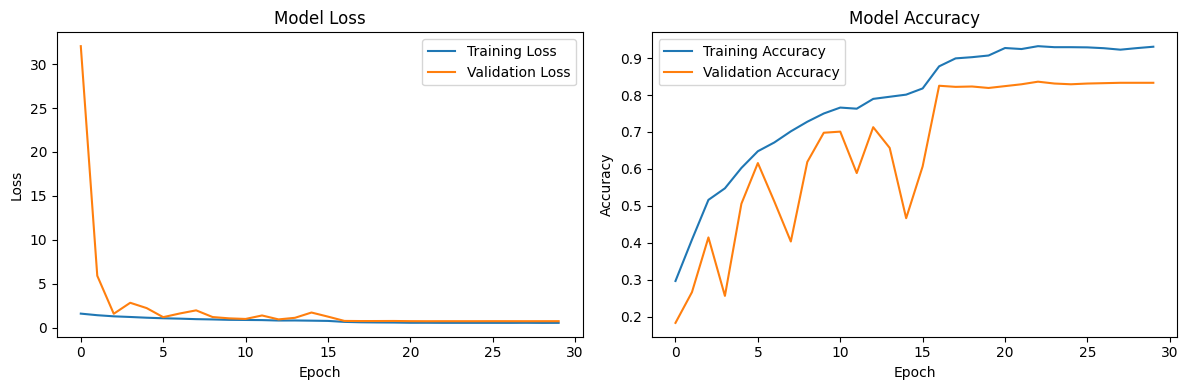

In [17]:
# 훈련 기록 시각화
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # 손실 그래프
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # 정확도 그래프
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)